In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle
from scipy.optimize import fsolve

# A working model for the dendrite only

Adapted from Wong & Wang (2006) and Yang (2020), this model includes two multi-compartment excitatory cell populations. The dendritic compartment takes in recurrent excitation, and stimulus is received directly by the population's somatic compartment. To replicate cross-inhibition, each excitatory population sends excitatory input to a globally inhibiting population, PV. (There is no selective inhibition.) The PV neuron population is also self-excitatory.

In [2]:
# default equation params
def default_params(**kwargs):
    p = {}
    
    p['a'] = 270
    p['b'] = 108
    p['d'] = 0.11
    
    p['gamma'] = 0.641         # unitless
    p['tS'] = 0.1              # [s] Time scale of synaptic gating
    p['tauGABA'] = 0.005 #[s]

    # Stimulus
    p['mu0'] = 30              # [Hz]
    p['Jext'] = 1.1e-3        # [nA/Hz]
    p['coh'] = 0
    
    # simulation parameters
    p['Ntrials'] = 5
    p['totalTime'] = 5         # [s]
    p['dt'] = .001             # [s]
    p['smooth_dt'] = 0.02
    p['Tstim'] = 1.    # Time of stimulus 1 onset [sec]
    p['Tdur'] = 2.     # Duration of stimulus 1 [sec]
    
    #Flexible Control
    p['rI'] = 0
   
    # noise parameters
    p['tau0'] = 0.002          # [s] noise time constant
    p['sigma'] = 0.002          # noise magnitude [nA]
    
    # Voltage function fit
    p['b_g'] = 5.56
    p['k'] = 9.64                #[nS]
    p['gamma2'] = 6.54           #[nsiemens]
    p['V_0'] = 0.78              #[mv]
    
    # Connection Strenghts
    p['jEI'] = 0.3
    p['jIE'] = -0.5 #nA
    p['jII'] = -0.22
    p['jDS'] = 0.6 # unitless
    p['I0'] = 0.47
    p['IbP'] = 0.38
    
    ### Dendrite to Soma ###
    p['gDS'] = 8 # Total dendrite-soma coupling of all dendrites. [nS] = [A/V 1e-9] 
    p['gLD'] = 4. # Leak conductance [nS]
    p['N_NMDA'] = 15 # unitless number of NMDA synapses
    p['g_NMDA'] = 2.5 #[nS] maximum NMDA synaptic conductance
    p['tau_NMDA_rise'] = 2e-3 #[s]
    p['tau_NMDA_decay'] = 100e-3 #[s]
    p['alpha_NMDA'] = 0.3e3 #[1/s]
    p['g_GABA'] = 4.0 #[nsiemens] maximum GABA synaptic conductance
    
    p.update(kwargs)

    return p

In [3]:
p = default_params()
with open('default_parameters.p', 'wb') as file:
    pickle.dump(p, file)

### Transfer Function

\begin{equation}
F(I) = \frac{aI - b}{1 - e^{-d(aI -b)}} \\
\end{equation}

In [4]:
# Transfer function

def F(I, a=270, b=108, d=0.154):
    # rate [Hz] as a function of total input current [nA]
    return (a*I - b + 1e-8)/(1. - np.exp(-d*(a*I - b + 1e-8)))


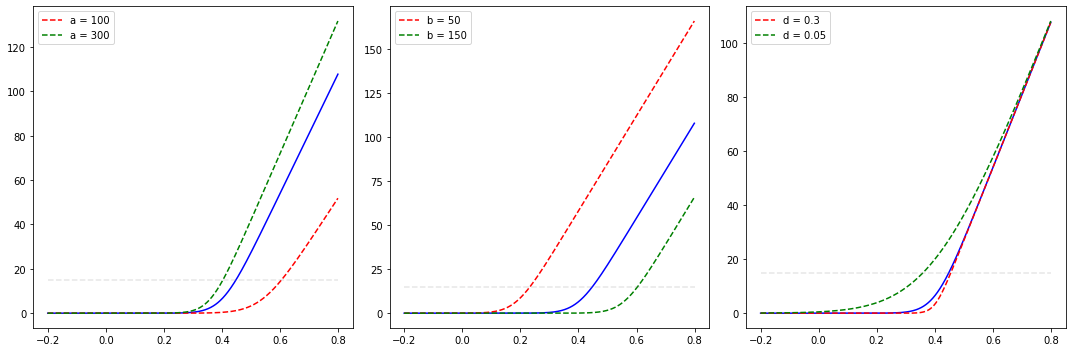

In [5]:
# Varying parameters in the transfer function.

fig, axs = plt.subplots(1,3, figsize = (15,5), sharey= False)
I = np.arange(-0.2, 0.8, 0.001)
axs[0].plot(I, F(I), c = 'blue')
axs[0].plot(I, F(I, a = 200),c = 'red', label = 'a = 100', ls = '--')
axs[0].plot(I, F(I, a = 300),c = 'green', label = 'a = 300', ls = '--')
axs[0].hlines(15, -0.2, 0.8, ls = '--', color = 'grey', alpha = 0.2)
axs[0].legend()

axs[1].plot(I, F(I), c = 'blue')
axs[1].plot(I, F(I, b = 50), c = 'red', label = 'b = 50', ls = '--')
axs[1].plot(I, F(I, b = 150), c = 'green', label = 'b = 150', ls = '--')
axs[1].hlines(15, -0.2, 0.8, ls = '--', color = 'grey', alpha = 0.2)
axs[1].legend()

axs[2].plot(I, F(I), c = 'blue')
axs[2].plot(I, F(I, d = 0.3), c = 'red', label = 'd = 0.3', ls = '--')
axs[2].plot(I, F(I, d = 0.05), c = 'green', label = 'd = 0.05', ls = '--')
axs[2].hlines(15, -0.2, 0.8, ls = '--', color = 'grey', alpha = 0.2)
plt.legend()
plt.tight_layout()

In [6]:
F(0.35)

1.9295449007468994

### Dendrite compartment


The time averaged voltage of a dendritic compartment is a sigmoidal function of total excitatory input conductance ($g_E$).  

\begin{equation}
\overline{V_D} = f_V(\bar{g_E}, \bar{g_I}) = 30 \times \left[1 + \tanh\left(\frac{\overline{g_E} - g_{1/2}}{\beta}\right)\right] + V_0 + E_L
\end{equation}

$\overline{g_E}$ and $\overline{g_I}$ are the time-averaged total conductance of all excitatory and inhibitory synapses.
$g_{1/2}$ is the midpoint proportional to the total inihibitory conductance $g_I$.  

\begin{align}
&g_{1/2} = b_g(g_\mathrm{LD} + g_{I}) \\
&\overline{g_I} = \tau_\mathrm{GABA} \tilde{g}_\mathrm{GABA}\cdot r_I \\
&\overline{g_E} = N_\mathrm{NMDA}\tilde{g}_\mathrm{NMDA} \cdot \overline{s}_\mathrm{i} \\
\end{align}

where $N_\mathrm{NMDA}$ is the number of synapses for NMDAR-only excitatory input, $\tilde{g_\mathrm{NMDA}}$ is the maximal conductance of the synapse. $s_i$ is the time-dependent gating variable. The excitatory conductance saturates as the gating variable does.<br>

The output firing rate is a function of the sum of input current from dendrites and the somatic inhibition from PV neurons if applicable.

$$ I = G_C \cdot (\langle V_D \rangle - E_\mathrm{reset}) $$

Somatic voltage fluctuates around $E_\mathrm{reset} = 55 \mathrm{mV}$ and there is a mean dendritic voltage $V_D$.

In [7]:
def VD(si, rI, p):
    '''
    time averaged dendritic voltage as a function of any excitatory and inhibitory rates
    '''
    
    # time-averaged gating variable if a single synapse receiving input rate r_E
    s_pyrNMDA = si #si # dynamic
    
    gE = p['N_NMDA']*p['g_NMDA']*(si) #excitatory conductance [nS]
    gI = rI*p['tauGABA']*p['g_GABA'] #inhibitory conductance [nS]
    
    midpoint = p['b_g']*(p['gLD'] + gI) # midpoint [nS]
    width = p['k']*np.exp(gI/p['gamma2']) # [nS]

    return 30*(1 + np.tanh((gE - midpoint)/width)) + 0.78 - 70 #mV

def IDtoS(VD):
    # VD is in [mV] and I is in nA
    return 8*(VD + 55)*1e-3

In [8]:
IDtoS(VD(0.1,0,p = default_params()))

-0.10362151660206963

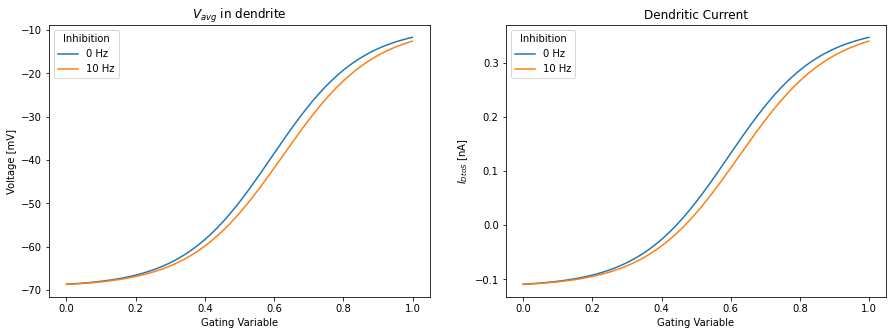

In [9]:
# Plotting the dendritic voltage

p = default_params()
si = np.arange(0, 1, 0.001)


fig, ax = plt.subplots(1, 2, figsize = (15,5),sharey = False)

ax[0].set(title = r"$V_{avg}$ in dendrite", xlabel = "Gating Variable", ylabel = "Voltage [mV]")
ax[0].plot(si, VD(si, 0, p), label = '0 Hz')
ax[0].plot(si, VD(si, 10, p), label = '10 Hz')
ax[0].legend(title = "Inhibition")

ax[1].set(title = "Dendritic Current", xlabel = 'Gating Variable', ylabel = r'$I_{DtoS}$ [nA]')
ax[1].plot(si, IDtoS(VD(si, 0, p)), label = '0 Hz')
ax[1].plot(si, IDtoS(VD(si, 10, p)), label = '10 Hz')
ax[1].legend(title = "Inhibition")

## Main Simulation Code


There are three main drive variables in our system:

\begin{align}
\frac{dS_1}{dt} &= -\frac{S_1}{\tau_s} + r(I_1)\,\gamma\,(1-S_1) \\
\frac{dS_2}{dt} &= -\frac{S_2}{\tau_s} + r(I_2)\,\gamma\,(1-S_2) \\
\frac{dS_{PV}}{dt} &= -\frac{S_{PV}}{\tau_{GABA}} + r(I_{PV})\,\gamma\,(1-S_{PV}) \\
\end{align}

where the input current is given by

\begin{align}
&I_1 = J_{IE}\,S_{PV} + J_{DS}\,I_{dend}(S_1) + I_{stim, 1} + I_{bg} + I_{noise} \\ 
&I_2 = J_{IE}\,S_{PV} + J_{DS}\,I_{dend}(S_2) + I_{stim, 2} + I_{bg} + I_{noise} \\ 
&I_{PV} = J_{II}\,S_{PV} + J_{EI}\,S_1 + J_{EI}\,S_2 + I_{bg, PV} \\
\end{align}


The circuit is now parametrized by

$J_\mathrm{EI}$: Excitation strength from excitatory population to inhibitory population PV <br>
$J_\mathrm{II}$: PV self-inhibition strength <br>
$J_\mathrm{IE}$: Inhibition strength from PV to excitatory populations <br>
$J_\mathrm{DS}$: Dendrite to soma connection strength <br>


In [10]:
def simulate_Dend(p, extraParams = None):
    if extraParams:
        for key in extraParams:
            p[key] = extraParams[key]
            
    r1list = []
    r2list = []
    Idend1list = []
    Idend2list = []
    I1list = []
    I2list = []
    IPVlist = []
    s1list = []
    s2list = []
    sPVlist = []
    
    for i in range(p['Ntrials']):
        
        t_range = np.arange(0, p['totalTime'], p['dt'])
        n_steps = t_range.size

        # initialize
        s1 = np.zeros(n_steps) # self excitation 1
        s2 = np.zeros(n_steps) # self excitation 2
        sp = np.zeros(n_steps) # self inhibition

        Idend1 = np.zeros(n_steps)
        Idend2 = np.zeros(n_steps)

        I1 = np.zeros(n_steps)
        I2 = np.zeros(n_steps)
        IPV = np.zeros(n_steps)

        r1 = np.zeros(n_steps)
        r2 = np.zeros(n_steps)
        rPV = np.zeros(n_steps)

        Ieta1 = np.zeros(n_steps)
        Ieta2 = np.zeros(n_steps)

        # Background input
        Ib1 = p['I0']/2
        Ib2 = p['I0']/2
        IbP = p['IbP']
        
        # inhibition
        rI = p['rI']

        # Gating variables
        jDS = p['jDS']
        jIE = p['jIE']
        jEI = p['jEI']
        jII = p['jII']

        # ---------- forward euler --------------
        for t in range(n_steps - 1):
            ifstim = ((p['Tstim']/p['dt'] < t) & (t<(p['Tstim']+p['Tdur'])/p['dt']))

            # Stimulus
            Istim1 = ifstim*(p['Jext']*p['mu0'])*(1 + p['coh']/100) # To population 1
            Istim2 = ifstim*(p['Jext']*p['mu0'])*(1 - p['coh']/100) # To population 2

            # Dendrite                     
            Idend1[t] = 8*(VD(s1[t], rI, p) + 55)*1e-3
            Idend2[t] = 8*(VD(s2[t], rI, p) + 55)*1e-3

            # calculate I [nA]
            I1[t] = jIE*sp[t] + jDS*Idend1[t] + Istim1 + Ib1 + Ieta1[t]
            I2[t] = jIE*sp[t] + jDS*Idend2[t] + Istim2 + Ib2 + Ieta2[t]
            IPV[t] = jII*sp[t] + jEI*s1[t] + jEI*s2[t] + IbP

            # calculate r (rate) [Hz]
            r1[t] = F(I1[t])
            r2[t] = F(I2[t])
            rPV[t] = F(IPV[t])

            # update s [unitless and should be between 0 and 1]
            s1[t+1] = s1[t] + p['dt']*(-s1[t]/p['tS'] + (1 - s1[t])*p['gamma']*r1[t])
            s2[t+1] = s2[t] + p['dt']*(-s2[t]/p['tS'] + (1 - s2[t])*p['gamma']*r2[t])
            sp[t+1] = sp[t] + p['dt']*(-sp[t]/p['tauGABA'] + (1 - sp[t])*p['gamma']*rPV[t])

            # Noise generation
            Ieta1[t+1] = Ieta1[t] + (p['dt']/p['tau0'])*(Ib1-Ieta1[t]) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*np.random.randn()
            Ieta2[t+1] = Ieta2[t] + (p['dt']/p['tau0'])*(Ib2-Ieta2[t]) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*np.random.randn()

        bin_count = int(p['smooth_dt']/p['dt'])

        r1smooth = np.array([np.mean(r1[j:j+bin_count]) for j in range(n_steps)])
        r2smooth = np.array([np.mean(r2[j:j+bin_count]) for j in range(n_steps)])
        
        r1list.append(r1smooth)
        r2list.append(r2smooth)
        s1list.append(s1)
        s2list.append(s2)
        sPVlist.append(sp)
        Idend1list.append(Idend1)
        Idend2list.append(Idend2)
        I1list.append(I1)
        I2list.append(I2)
        IPVlist.append(IPV)
        
        
    return {'trange':t_range, 
            'r1': np.array(r1list), 
            'r2': np.array(r2list),
            's1': np.array(s1list),
            's2': np.array(s2list),
            'sp' : np.array(sPVlist),
            'Idend1': np.array(Idend1list),
            'Idend2': np.array(Idend2list),
            'I1': np.array(I1list),
            'I2': np.array(I2list),
            'IPV': np.array(IPVlist)
           }

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


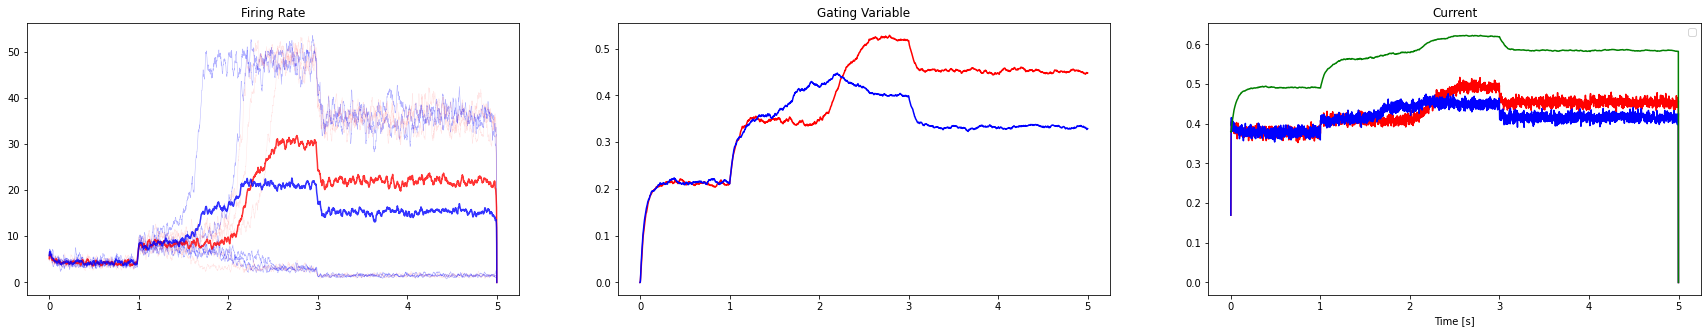

In [11]:
pars = default_params(sigma = 0.02)

res = simulate_Dend(pars)

fig, axs = plt.subplots(1, 3, figsize=(30, 5))
for i in range(5):
    axs[0].plot(res['trange'], res['r1'][i, :], c='r', alpha=0.1, lw=0.5)
    axs[0].plot(res['trange'], res['r2'][i, :], c='b', alpha=0.3, lw=0.5)
    
t = res['trange']
axs[0].set(title = 'Firing Rate')
axs[0].plot(t, res['r1'].mean(axis=0), c='r', alpha=0.8)
axs[0].plot(t, res['r2'].mean(axis=0), c = 'b', alpha = 0.8)

axs[1].set(title = 'Gating Variable')
axs[1].plot(t, res['s1'].mean(axis=0), c = 'r')
axs[1].plot(t, res['s2'].mean(axis=0), c = 'b')

axs[2].set(title = 'Current')
axs[2].plot(res['trange'], res['I1'].mean(axis=0), c = 'r')
axs[2].plot(res['trange'], res['I2'].mean(axis=0), c= 'b')
axs[2].plot(res['trange'], res['IPV'].mean(axis=0), c = 'g')

plt.xlabel('Time [s]')
plt.legend()
plt.show()

In [12]:
def fraction_correct(ntrials, p = None, threshold = 12):
    '''
    Threshold value must be in Hz
    '''
    if p == None:
        p = default_params()
        
    p['Ntrials'] = ntrials
    
    

# A circuit with pooled inhibition (PV) only

## Nullclines

Population 1 is described be the equations

\begin{align}
S_1 &= \frac{\tau_s\,F(I_1)\,\gamma}{1 + \tau_s\,F(I_1)\,\gamma} \\
I_1 &= J_{IE} S_{PV} + J_{DS} I_{Dend}(S_1) + I_\mathrm{stim1} + I_{bg} + I_{n} \\
S_{PV} &= \frac{1}{J_{IE}} \left( I_1 - J_{DS}I_{Dend}(S_1) - I_{\mathrm{stim1}} - I_{bg} - I_n \right)\\ 
\end{align}

Using steady state $S_{PV}$:

\begin{align}
S_{PV} &= \frac{\tau_{GABA}F(I_{PV})\gamma}{1 + \tau_{GABA} F(I_{PV}) \gamma} \\ 
I_{PV} &= J_{II} S_{PV} + J_{EI} S_{1} + J_{EI} S_2 + I_{bg, PV}\\
S_2 &= \frac{1}{J_{EII}} \left(I_{PV} + J_{II}S_{PV} - J_{IE}S_1 - I_{bg, PV} \right)
\end{align}


Same for Population 2

0.11006995476907426
0.21259211788903432


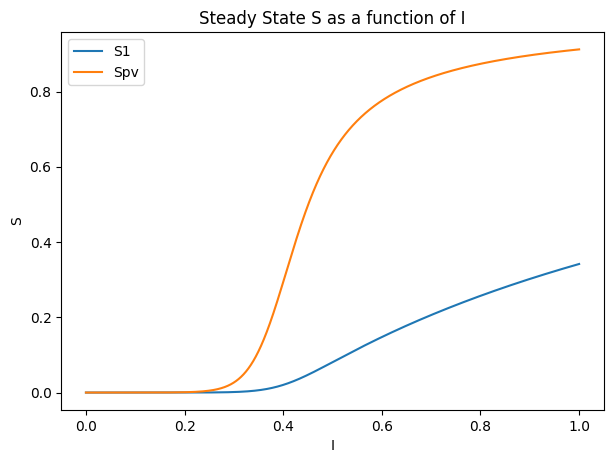

In [12]:
def s_steady(I, tau, gamma):
    return tau*F(I)*gamma/(1 + tau*F(I)*gamma)

I = np.linspace(0, 1, 10000)
fig, ax = plt.subplots(figsize = (7,5), sharey=True, dpi = 100)
ax.plot(I, s_steady(I, p['tauGABA'], p['gamma']), label = 'S1')
ax.plot(I, s_steady(I, p['tS'], p['gamma']), label = "Spv")
ax.set(title = "Steady State S as a function of I", ylabel = "S", xlabel = "I")
ax.legend()
print(s_steady(0.35, p['tS'], p['gamma']))
print(s_steady(0.712, p['tauGABA'], p['gamma']))

In [13]:
def Nullcline_S1(p, I1, ifstim=False, rI = 0, fixed_range=True):
    """ Obtain nullcline for population 1 parametrized by I1 """
    
    tauS, tauG, gamma = p['tS'], p['tauGABA'], p['gamma']
    jIE, jEI, jII, jDS = p['jIE'], p['jEI'], p['jII'], p['jDS']
    Ib1, IbPV = p['I0'], p['IbP']
    a, b, d = p['a'], p['b'], p['d']
    Istim1 = ifstim*(p['Jext']*p['mu0'])*(1 + p['coh']/100) # To population 1

    S1 = F(I1, a, b, d)*gamma/(1./tauS + F(I1, a, b, d)*gamma)
    Ids = 8*(VD(S1, p['rI'], p) + 55)*1e-3
    SPV = (I1 - jDS*Ids - Istim1 - Ib1)/jIE 
    
    # solve for IPV
    def IPV_solver(IPV, SPV, p):
        return p['gamma']*F(IPV, a, b, d)/(1./tauG + p['gamma']*F(IPV, a, b, d)) - SPV
    
    try:
        IPV, S2 = np.zeros(SPV.size), np.zeros(SPV.size)
        for i, sP in enumerate(SPV):
            IPV[i] = fsolve(IPV_solver, 0.5, (sP, p))[0]
            S2[i] = (IPV[i] - jII*sP - jEI*S1[i] - IbPV)/jEI
    except TypeError as te:
        IPV = fsolve(IPV_solver, 0.5, (SPV, p))[0]
        S2 = (IPV - jII*SPV - jEI*S1 - IbPV)/jEI
        
    if fixed_range:
        id_range = (S2>=-0.0) &(S2<=1.2)
    else:
        id_range = S2<=1e5
        
    return S1[id_range], S2[id_range]

In [14]:
def Nullcline_S2(p, I2, ifstim = False, rI = 0, fixed_range = True):
    
    tauS, tauG, gamma = p['tS'], p['tauGABA'], p['gamma']
    jIE, jEI, jII, jDS = p['jIE'], p['jEI'], p['jII'], p['jDS']
    Ib2, IbPV = p['I0'], p['IbP']
    a, b, d = p['a'], p['b'], p['d']
    Istim2 = ifstim*(p['Jext']*p['mu0'])*(1 - p['coh']/100)

    S2 = tauS*F(I2, a, b, d)*gamma/(1 + tauS*F(I2, a, b, d)*gamma)
    Ids = 8*(VD(S2, p['rI'], p) + 55)*1e-3
    SPV = (I2 - jDS*Ids - Istim2 - Ib2)/jIE 
    
    # solve for IPV
    def IPV_solver(IPV, SPV, p):
        return p['gamma']*F(IPV, a, b, d)/(1./tauG + p['gamma']*F(IPV, a, b, d)) - SPV
    
    try:
        IPV, S1 = np.zeros(SPV.size), np.zeros(SPV.size)
        for i, sP in enumerate(SPV):
            IPV[i] = fsolve(IPV_solver, 0.5, (sP, p))[0]
            S1[i] = (IPV[i] - jII*sP - jEI*S2[i] - IbPV)/jEI
    except TypeError as te:
        IPV = fsolve(IPV_solver, 0.1, (SPV, p))[0]
        S1 = (IPV - jII*SPV - jEI*S2 - IbPV)/jEI
        
    if fixed_range:
        id_range = (S1>=-0.0) &(S1<=1.2)
    else:
        id_range = S1<=1e5
        
    return S1[id_range], S2[id_range]

In [15]:
def derivs(s1, s2, p, ifstim = False):
    def sp_solver(x, s1, s2, p):
        Ibp = p['IbP']
        jII, jEI = p['jII'], p['jEI']
        a, b, d = p['a'], p['b'], p['d']
        gamma, tauG = p['gamma'], p['tauGABA']

        IPV = jII*x + jEI*s1 + jEI*s2 + Ibp
        rhs = gamma*F(IPV, a, b, d)/(1./tauG + gamma*F(IPV, a, b, d))
        return x - rhs
    
    sp = fsolve(sp_solver, 0.5, (s1, s2, p))
    
    jIE, jEI, jII, jDS = p['jIE'], p['jEI'], p['jII'], p['jDS']
    tauS, gamma = p['tS'], p['gamma']
    Ib1, Ib2 = p['I0'], p['I0']
    a, b, d = p['a'], p['b'], p['d']
    Istim1 = ifstim*(p['Jext']*p['mu0'])*(1 + p['coh']/100) # To population 1
    Istim2 = ifstim*(p['Jext']*p['mu0'])*(1 - p['coh']/100) # To population 2

    Idend1 = 8*(VD(s1, p['rI'], p) + 55)*1e-3
    Idend2 = 8*(VD(s2, p['rI'], p) + 55)*1e-3
    
    I1 = jIE*sp + jDS*Idend1 + Istim1 + Ib1
    I2 = jIE*sp + jDS*Idend2 + Istim2 + Ib2
    
    dS1dt = -s1/tauS + F(I1, a, b, d)*gamma*(1.0 - s1)
    dS2dt = -s2/tauS + F(I2, a, b, d)*gamma*(1.0 - s2)
    
    return dS1dt, dS2dt

In [16]:
def plot_phase_plane(pars, plot_thres = 1, stimulus = False, ax = None, vecflow = True, nullclines = True, rc = 'r', bc = 'b', ls = 'solid'):
    if ax == None:
        plt.gca()
                     
    if nullclines:
        I1_null = np.linspace(0, 1.0, 10000)
        I2_null = np.linspace(0, 1.0, 10000)
        S1_null_S1, S1_null_S2 = Nullcline_S1(pars, I1_null, ifstim = stimulus, fixed_range=False)
        S2_null_S1, S2_null_S2 = Nullcline_S2(pars, I2_null, ifstim = stimulus, fixed_range=False)
        
        plot_range = (S1_null_S1<plot_thres)&(S1_null_S2<plot_thres)
        ax.plot(S1_null_S2[plot_range], S1_null_S1[plot_range], c = rc, label='S1 nullcline', ls = ls)
        plot_range = (S2_null_S1<plot_thres)&(S2_null_S2<plot_thres)
        ax.plot(S2_null_S2[plot_range], S2_null_S1[plot_range], c = bc, label='S2 nullcline', ls = ls)
    
    if vecflow:
        num = 200
        S_vec = np.linspace(0.001,0.999,num) # things break down at S=0 or S=1
        S1, S2 = np.meshgrid(S_vec,S_vec)

        dS1dt = np.zeros((num,num))
        dS2dt = np.zeros((num,num))

        for i in range(num-1):
            for j in range(num-1):
                dS1dt[i][j], dS2dt[i][j] = derivs(S1[i][j], S2[i][j], pars, ifstim = stimulus)

        n_skip = 12
        ax.quiver(S1[::n_skip,::n_skip], S2[::n_skip,::n_skip], 
                   dS1dt[::n_skip,::n_skip], dS2dt[::n_skip,::n_skip], 
                   angles='xy', scale_units='xy', scale=80,facecolor='gray')

    # ax.set_xlabel('$S_2$')
    # ax.set_ylabel('$S_1$')
    ax.set_xlim([0, plot_thres])
    ax.set_ylim([0, plot_thres])
    ax.set_aspect('equal')
    #ax.legend(loc='best')

### With and without stimulus using "best" parameters

By best, I mean best at replicating the following structure,

<img align="left" width="500" height="400" src="plots/wongwangattractors.png">

with free parameters $I_0$, $I_{bp}$, $J_{DS}$, $J_{IE}$, $J_{EI}$, $J_{II}$

/Users/harpercho/miniconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


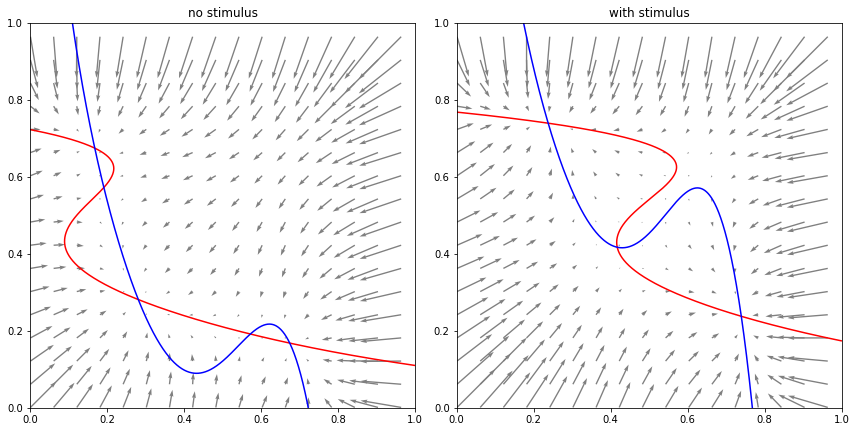

In [17]:
pars = default_params(mu0 = 25)

fig, axs = plt.subplots(1,2, figsize = (12,6))
axs[0].set(title = "no stimulus")
axs[1].set(title = "with stimulus")
plot_phase_plane(pars, plot_thres = 1, vecflow = True, stimulus = False, ax = axs[0])
plot_phase_plane(pars, plot_thres = 1, vecflow = True, stimulus = True, ax = axs[1])
plt.tight_layout()
plt.savefig('plots/DendriticRecursion.png')

### Changing Coherence

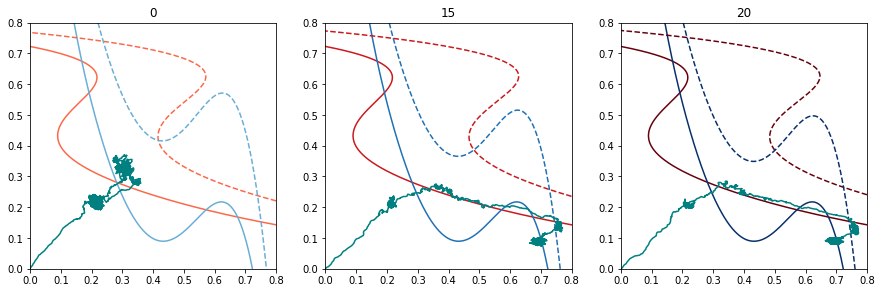

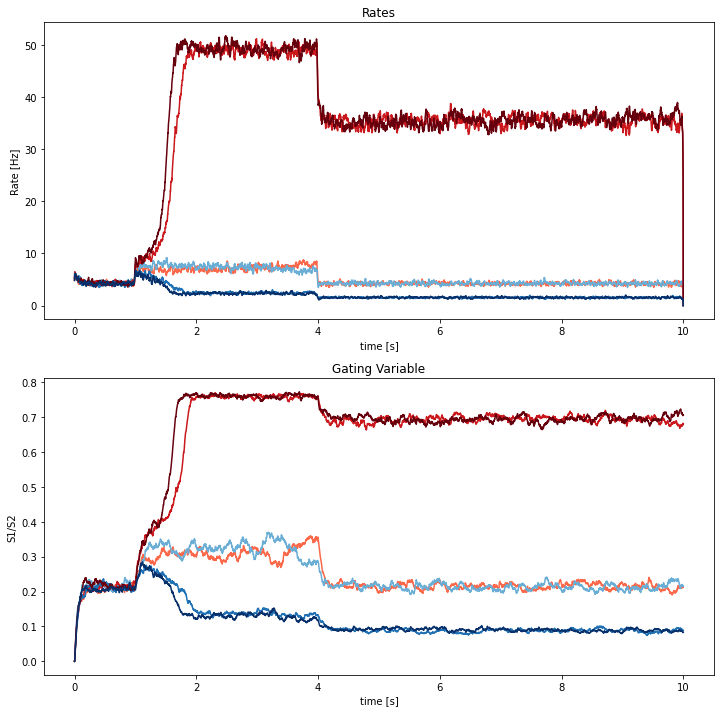

In [30]:
# Trying a simulation
def plot_simulation(c, ax, ax2, r = 'r', b = 'b', sigma = 0.02):

    p = default_params(totalTime = 10, sigma = 0.02, mu0 = 25, Tdur = 3, coh = c)
    res = simulate_Dend(p)
    s1 = res['s1'][0]
    s2 = res['s2'][0]
    r1 = res['r1'].mean(axis = 0)
    r2 = res['r2'].mean(axis = 0)
    t = res['trange']

    plot_phase_plane(p, plot_thres=0.8, vecflow=False, stimulus=False, ax = ax, rc = r, bc = b)
    plot_phase_plane(p, plot_thres=0.8, vecflow=False, stimulus=True, ax = ax, ls = '--', rc = r, bc = b)
    ax.plot(s1, s2, c='teal')
    
    ax2[0].set(title = "Rates", xlabel = "time [s]", ylabel = "Rate [Hz]")
    ax2[0].plot(t, r1, c = r)
    ax2[0].plot(t, r2, c = b)
    ax2[1].set(title = "Gating Variable", ylabel = "S1/S2", xlabel = "time [s]")
    ax2[1].plot(t, s1, c = r)
    ax2[1].plot(t, s2, c = b)

cmap_r = cm.Reds(np.linspace(0.5,1,3))
cmap_b = cm.Blues(np.linspace(0.5,1,3))

coh = [0, 15, 20]

fig, ax1 = plt.subplots(1, 3, figsize = (15,5))
fig, ax2 = plt.subplots(2, 1, figsize = (12, 12))


for r, b, c, ax in zip(cmap_r, cmap_b, coh, ax1):
    ax.set(title = str(c))
    plot_simulation(c, ax, ax2, r, b)

## Changing Variables

In [19]:
def plot_comparison(var, lowlim, highlim, p = None, n = 5, stim = False):
    if p == None:
        p = default_params
    
    var_list = np.linspace(lowlim, highlim, n)
    
    fig, axs = plt.subplots(1, n, figsize = (18,6))
    for ax, v, in zip(axs.flat, var_list):
        p[var] = v
        plot_phase_plane(p, plot_thres = 0.8, stimulus = False, ax = ax, vecflow = False)
        
        if stim:
            plot_phase_plane(p, plot_thres = 0.8, stimulus = True, ax = ax, ls = '--', vecflow = False)
        ax.set_title(var + " " + str(round(v,2)))

### Adjusting background currents

Controls position of initial attractor

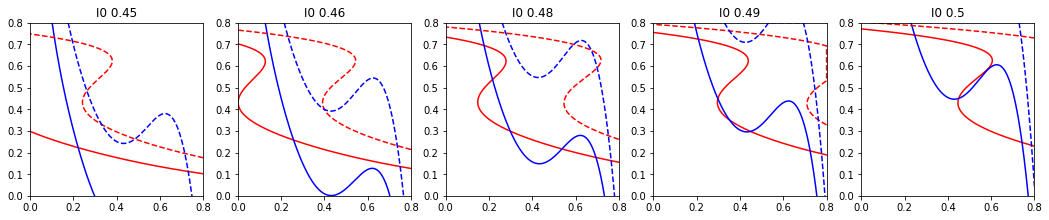

In [20]:
# Adjust background current
p = default_params()
plot_comparison('I0', 0.45, 0.5, p = p, stim = True)

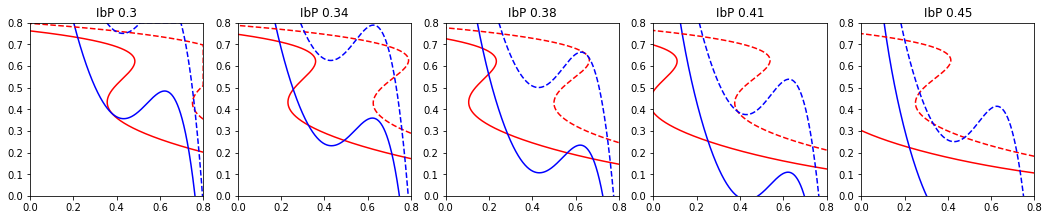

In [21]:
# Adjust background inhibition
p = default_params()
plot_comparison('IbP', 0.3, 0.45, p = p, stim = True)

### Adjusting Connection Strengths

Includes $J_{DS}$, $J_{IE}$, $J_{EI}$, $J_{II}$

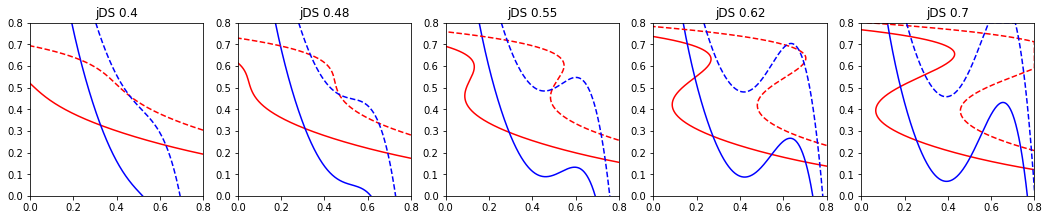

In [22]:
p = default_params()
plot_comparison('jDS', 0.4, 0.7, p = p, stim = True)

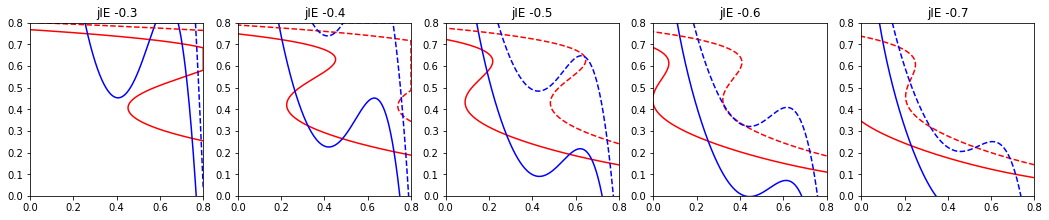

In [23]:
p = default_params()
plot_comparison('jIE', -0.3, -0.7, p = p, stim = True)

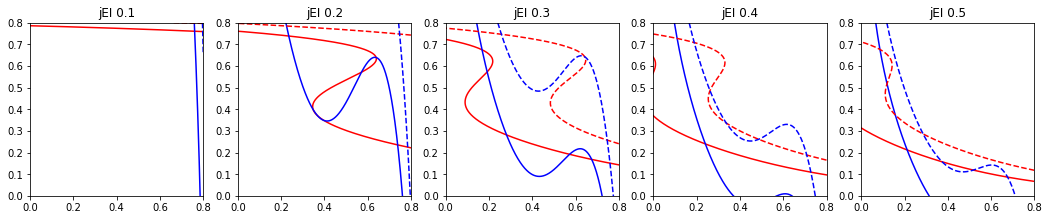

In [24]:
p = default_params()
plot_comparison('jEI', 0.1, 0.5, p=p, stim = True)

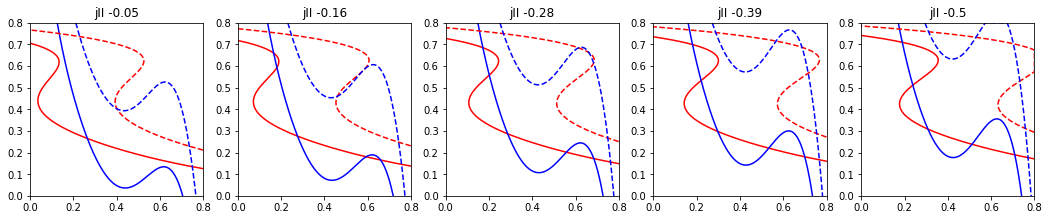

In [25]:
p = default_params()
plot_comparison('jII', -0.05, -0.5, p, stim = True)

### Adjusting Transfer Function Properties

The transfer function is modulated by the variables a, b, d. Default is a=270, b=108, d=0.154

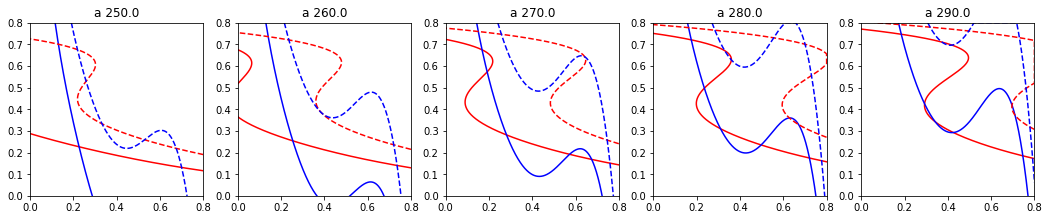

In [26]:
p = default_params()
plot_comparison('a', 250, 290, p = p, stim = True)

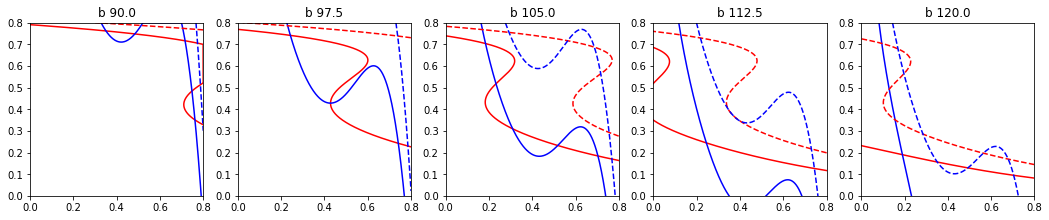

In [27]:
p = default_params()
plot_comparison('b', 90, 120, p = p, stim = True)

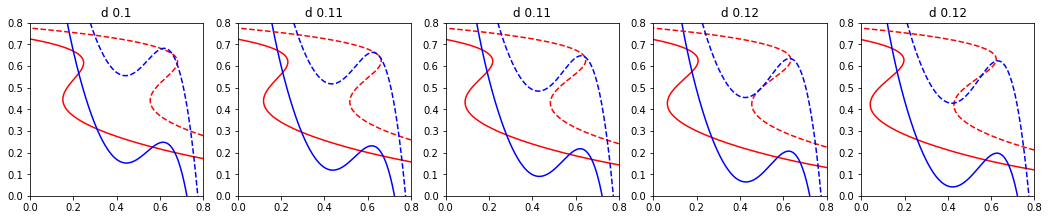

In [28]:
p = default_params()
plot_comparison('d', 0.1, 0.12, p, stim = True)

### Adjusting Dendritic Voltage Function Properties

Changing connection strengths does change the relative hights of local minima and maxima, but does not change their location with respect to the initial variable (S1 for the S1 nullcline and S2 for the S2 nullcline, etc). Our goal however is to narrow down the curved activity. We want the local maximum to occur <0.5.

Consider changin the following variables: p['k'] which controls $\beta$, $N_\mathrm{NMDA}$

\begin{equation}
\overline{V_D} = f_V(\bar{g_E}, \bar{g_I}) = 30 \times \left[1 + \tanh\left(\frac{\overline{g_E} - g_{1/2}}{\beta}\right)\right] + V_0 + E_L
\end{equation}

$\overline{g_E}$ and $\overline{g_I}$ are the time-averaged total conductance of all excitatory and inhibitory synapses.
$g_{1/2}$ is the midpoint proportional to the total inihibitory conductance $g_I$.  

\begin{align}
&g_{1/2} = b_g(g_\mathrm{LD} + g_{I}) \\
&\overline{g_I} = \tau_\mathrm{GABA} \tilde{g}_\mathrm{GABA}\cdot r_I \\
&\overline{g_E} = N_\mathrm{NMDA}\tilde{g}_\mathrm{NMDA} \cdot \overline{s}_\mathrm{i} \\
\end{align}


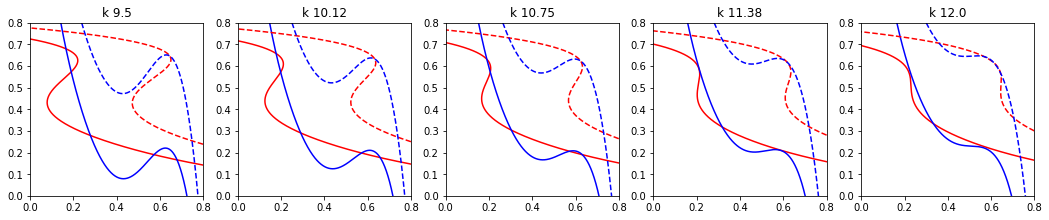

In [29]:
# Adjusting k
p = default_params()
plot_comparison('k', 9.5, 12, p, stim = True)

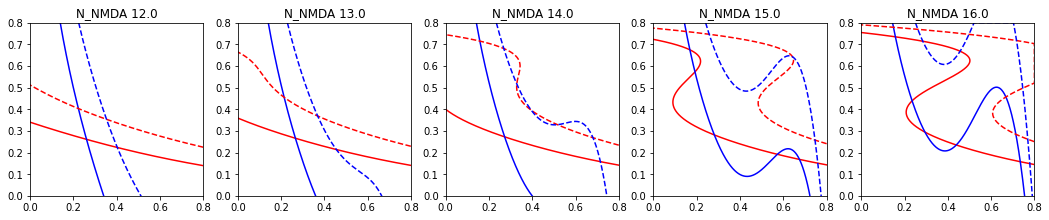

In [30]:
# Adjusting N
p = default_params()
plot_comparison('N_NMDA', 12, 16, p, stim = True)

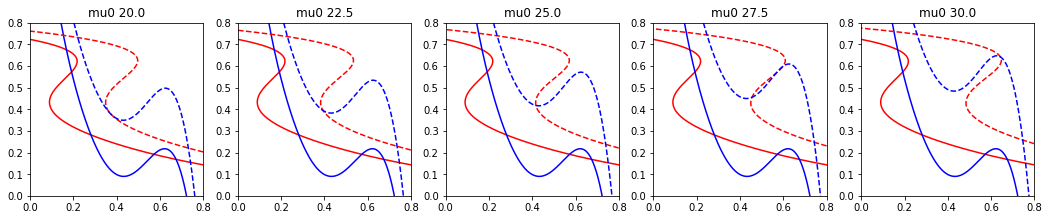

In [31]:
# stronger stimulus
p = default_params()
plot_comparison('mu0', 20, 30, p, stim = True)

# Inhibiting the dendrite

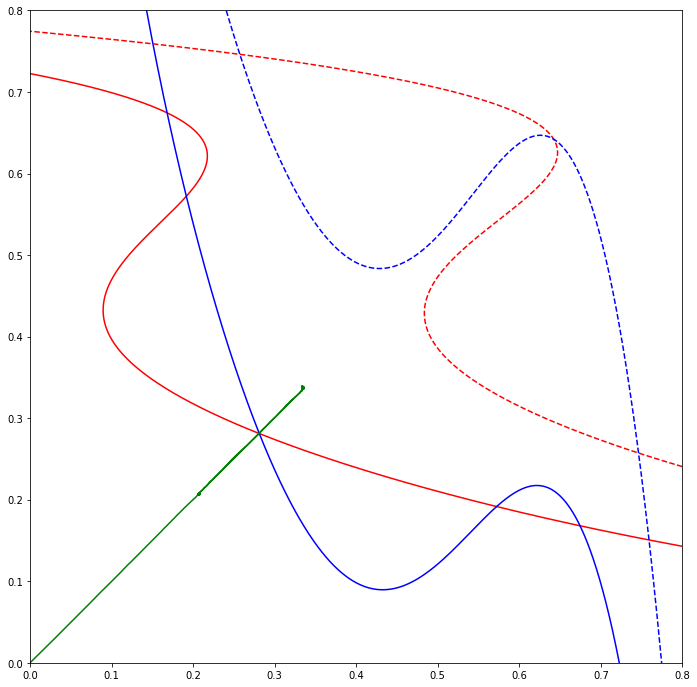

In [32]:
# Inhibiting both dendrites
p = default_params(coh = 0)
fig, ax = plt.subplots(figsize = (12,12))
plot_phase_plane(p, plot_thres=0.8, ax=ax, vecflow=False, nullclines=True)
plot_phase_plane(p, plot_thres=0.8, stimulus=True, ax = ax, vecflow=False, nullclines=True, ls = '--')

# simulation
res = simulate_Dend(p) # simualtion at coh = 0
s1_sim = res['s1'].mean(axis = 0)
s2_sim = res['s2'].mean(axis = 0)
ax.plot(s1_sim, s2_sim, color = 'g')

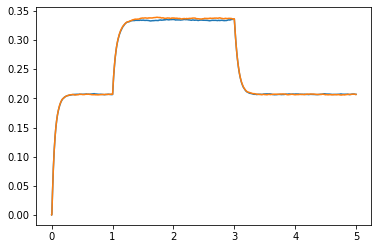

In [33]:
plt.plot(res['trange'], s1_sim)
plt.plot(res['trange'], s2_sim)

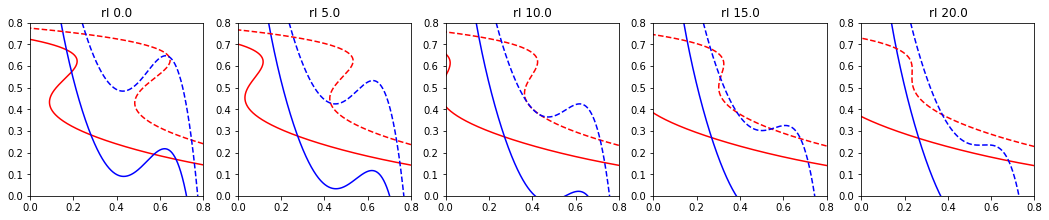

In [42]:
# Increasing Inhibition
p = default_params()
plot_comparison('rI', 0, 20, p=p, stim = True)

## Disinhibitory circuit

Next,  I want to create a disinhibitory circuit as follows:

We assume that the some neuron fires at a steady state rate of 5 Hz

\begin{equation}
r_\mathrm{SOM} = \mathrm{max}(0, \beta_{\mathrm{SOM}}(I_\mathrm{syn, SOM} - I_\mathrm{rh, SOM}))
\end{equation}

$$I_\mathrm{rh,SOM} = 40 \mathrm{pA}$$ is them minimum current required to activate the neuron and $\beta_\mathrm{SOM} \mathrm{Hz/nA}$ is the f-I curve slope for SOM neurons. We want a baseline firing of SOM neurons ~ 10 Hz.

\begin{equation}
I_\mathrm{syn, SOM} = I_\mathrm{VIP} + J_\mathrm{1, SOM} s_1 + J_\mathrm{2, SOM} s_2 + I_\mathrm{SOM bg}
\end{equation}

We expect that the VIP neurons fire at 5Hz on average and are top down controlled. VIP interneurons not target by the control input fire at 0 Hz while those targeted fire at 5 Hz. In terms of firing curren

In [13]:
def fI_SOM(current):
    rheobase = 0.040 #pA
    fIslope = 90./1000 #Hz/nA
    rate = (current - rheobase)*fIslope
    rate = rate*(rate>0)
    return rate

In [14]:
def simulate_disinh(p, extraParams = None):
    '''
    necessary extra params:
    jES is multiplied to a gating variable so should have units of nA
    jSE is multiplied to Hz so should have unites of nA*s
    rVIP usually 5Hz
    TVIP1, TVIP2
    TVIP1dur, TVIP2dur
    '''
    
    if extraParams:
        for key in extraParams:
            p[key] = extraParams[key]
            
    r1list = []
    r2list = []
    s1list = []
    s2list = []
    sPVlist = []
    ISOM1list = []
    ISOM2list = []
    
    for i in range(p['Ntrials']):
        
        t_range = np.arange(0, p['totalTime'], p['dt'])
        n_steps = t_range.size

        # initialize
        s1 = np.zeros(n_steps) # self excitation 1
        s2 = np.zeros(n_steps) # self excitation 2
        sp = np.zeros(n_steps) # self inhibition

        Idend1 = np.zeros(n_steps)
        Idend2 = np.zeros(n_steps)

        I1 = np.zeros(n_steps)
        I2 = np.zeros(n_steps)
        IPV = np.zeros(n_steps)
        ISOM1 = np.zeros(n_steps)
        ISOM2 = np.zeros(n_steps)

        r1 = np.zeros(n_steps)
        r2 = np.zeros(n_steps)
        rPV = np.zeros(n_steps)
        rSOM1 = np.zeros(n_steps)
        rSOM2 = np.zeros(n_steps)

        Ieta1 = np.zeros(n_steps)
        Ieta2 = np.zeros(n_steps)

        # Background input
        Ib1 = p['I0']/2
        Ib2 = p['I0']/2
        IbP = p['IbP']
        
        # inhibition
        rI = p['rI']
        rVIP = p['rVIP']

        # Gating variables
        jDS = p['jDS']
        jIE = p['jIE']
        jEI = p['jEI']
        jII = p['jII']
        jSE = p['jSE'] # SOM to Exc
        jES = p['jES'] # Exc to SOM

        # ---------- forward euler --------------
        for t in range(n_steps - 1):
            ifstim = ((p['Tstim']/p['dt'] < t) & (t<(p['Tstim']+p['Tdur'])/p['dt']))
            ifVIP1 = ((p['TVIP1']/p['dt'] < t) & (t<(p['TVIP1'] + p['TVIP1dur'])/p['dt']))
            ifVIP2 = ((p['TVIP2']/p['dt'] < t) & (t<(p['TVIP2'] + p['TVIP2dur'])/p['dt']))

            # Stimulus
            Istim1 = ifstim*(p['Jext']*p['mu0'])*(1 + p['coh']/100) # To population 1
            Istim2 = ifstim*(p['Jext']*p['mu0'])*(1 - p['coh']/100) # To population 2

            # Dendrite                     
            Idend1[t] = 8*(VD(s1[t], rI, p) + 55)*1e-3
            Idend2[t] = 8*(VD(s2[t], rI, p) + 55)*1e-3
            
            # SOM
            ISOM1[t] = ifVIP1*rVIP + jES*s1[t] + jES*s2[t]
            ISOM2[t] = ifVIP2*rVIP + jES*s2[t] + jES*s1[t]
            rSOM1[t] = fI_SOM(ISOM1[t])
            rSOM2[t] = fI_SOM(ISOM2[t])

            # calculate I [nA]
            I1[t] = jIE*sp[t] + jSE*rSOM1[t] + jDS*Idend1[t] + Istim1 + Ib1 + Ieta1[t]
            I2[t] = jIE*sp[t] + jSE*rSOM2[t] + jDS*Idend2[t] + Istim2 + Ib2 + Ieta2[t]
            IPV[t] = jII*sp[t] + jEI*s1[t] + jEI*s2[t] + IbP

            # calculate r (rate) [Hz]
            r1[t] = F(I1[t])
            r2[t] = F(I2[t])
            rPV[t] = F(IPV[t])

            # update s [unitless and should be between 0 and 1]
            s1[t+1] = s1[t] + p['dt']*(-s1[t]/p['tS'] + (1 - s1[t])*p['gamma']*r1[t])
            s2[t+1] = s2[t] + p['dt']*(-s2[t]/p['tS'] + (1 - s2[t])*p['gamma']*r2[t])
            sp[t+1] = sp[t] + p['dt']*(-sp[t]/p['tauGABA'] + (1 - sp[t])*p['gamma']*rPV[t])

            # Noise generation
            Ieta1[t+1] = Ieta1[t] + (p['dt']/p['tau0'])*(Ib1-Ieta1[t]) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*np.random.randn()
            Ieta2[t+1] = Ieta2[t] + (p['dt']/p['tau0'])*(Ib2-Ieta2[t]) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*np.random.randn()

        bin_count = int(p['smooth_dt']/p['dt'])

        r1smooth = np.array([np.mean(r1[j:j+bin_count]) for j in range(n_steps)])
        r2smooth = np.array([np.mean(r2[j:j+bin_count]) for j in range(n_steps)])
        
        r1list.append(r1smooth)
        r2list.append(r2smooth)
        s1list.append(s1)
        s2list.append(s2)
        sPVlist.append(sp)
        ISOM1list.append(ISOM1)
        ISOM2list.append(ISOM2)
        
        
    return {'trange':t_range, 
            'r1': np.array(r1list), 
            'r2': np.array(r2list),
            's1': np.array(s1list),
            's2': np.array(s2list),
            'sp' : np.array(sPVlist),
            'ISOM1' : np.array(ISOM1list),
            'ISOM2' : np.array(ISOM2list)
           }

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


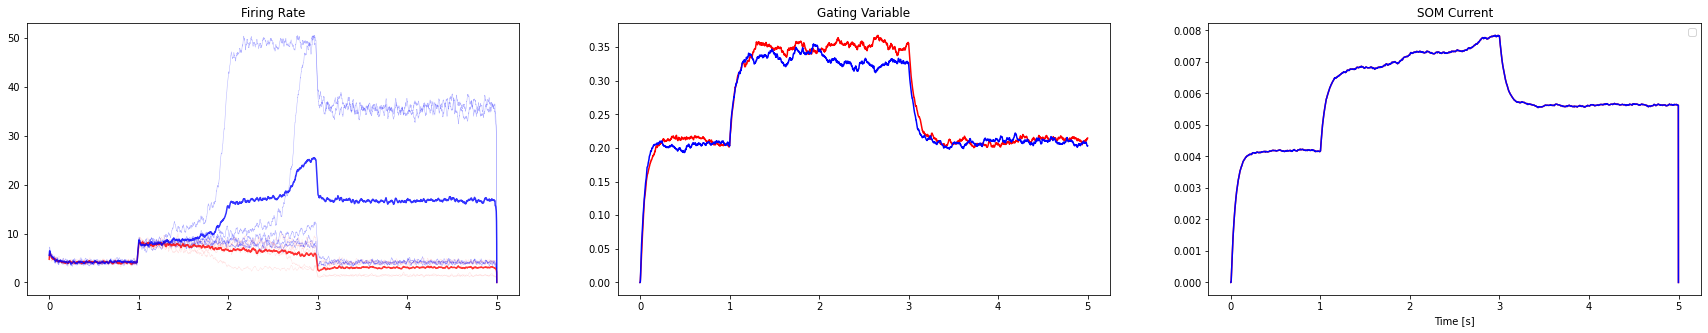

In [15]:
pars = default_params(jES = 0.01, jSE = 0.01, TVIP1 = 0, TVIP2 = 0, TVIP1dur =0, TVIP2dur = 0, rVIP = 5, sigma = 0.01)

res = simulate_disinh(pars)

fig, axs = plt.subplots(1, 3, figsize=(30, 5))
for i in range(5):
    axs[0].plot(res['trange'], res['r1'][i, :], c='r', alpha=0.1, lw=0.5)
    axs[0].plot(res['trange'], res['r2'][i, :], c='b', alpha=0.3, lw=0.5)
    
t = res['trange']
axs[0].set(title = 'Firing Rate')
axs[0].plot(t, res['r1'].mean(axis=0), c='r', alpha=0.8)
axs[0].plot(t, res['r2'].mean(axis=0), c = 'b', alpha = 0.8)

axs[1].set(title = 'Gating Variable')
axs[1].plot(t, res['s1'][0], c = 'r')
axs[1].plot(t, res['s2'][0], c = 'b')

axs[2].set(title = 'SOM Current')
axs[2].plot(res['trange'], res['ISOM1'].mean(axis=0), c = 'r')
axs[2].plot(res['trange'], res['ISOM2'].mean(axis=0), c = 'b')

plt.xlabel('Time [s]')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


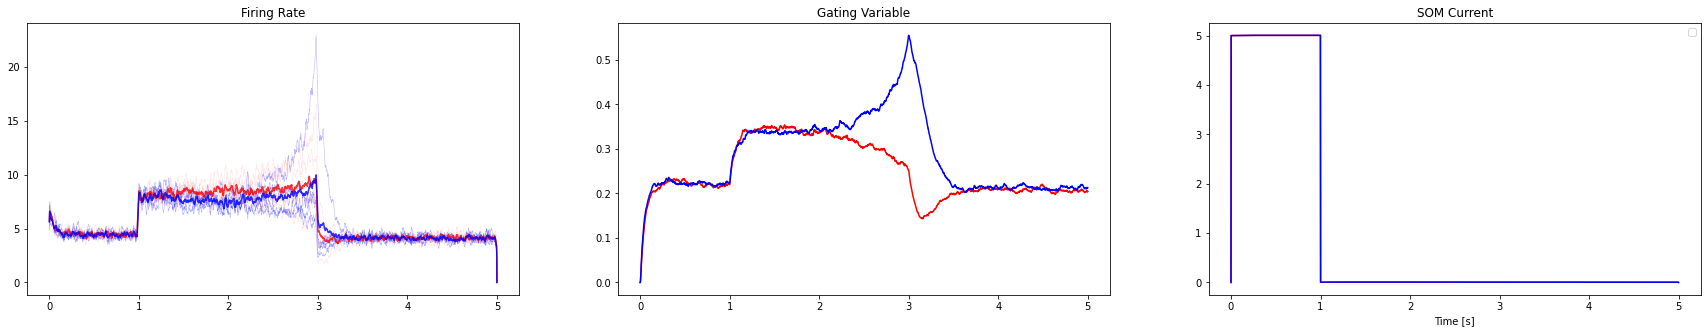

In [17]:
pars = default_params(jES = 0.01, jSE = 0.01, TVIP1 = 0, TVIP2 = 0, TVIP1dur =1, TVIP2dur = 1, rVIP = 5, sigma = 0.01)

res = simulate_disinh(pars)

fig, axs = plt.subplots(1, 3, figsize=(30, 5))
for i in range(5):
    axs[0].plot(res['trange'], res['r1'][i, :], c='r', alpha=0.1, lw=0.5)
    axs[0].plot(res['trange'], res['r2'][i, :], c='b', alpha=0.3, lw=0.5)
    
t = res['trange']
axs[0].set(title = 'Firing Rate')
axs[0].plot(t, res['r1'].mean(axis=0), c='r', alpha=0.8)
axs[0].plot(t, res['r2'].mean(axis=0), c = 'b', alpha = 0.8)

axs[1].set(title = 'Gating Variable')
axs[1].plot(t, res['s1'][0], c = 'r')
axs[1].plot(t, res['s2'][0], c = 'b')

axs[2].set(title = 'SOM Current')
axs[2].plot(res['trange'], res['ISOM1'].mean(axis=0), c = 'r')
axs[2].plot(res['trange'], res['ISOM2'].mean(axis=0), c = 'b')

plt.xlabel('Time [s]')
plt.legend()
plt.show()

In [53]:
def Nullcline_S1(p, I1, ifstim=False, ifVIP = False, rI = 0, fixed_range=True):
    """ Obtain nullcline for population 1 parametrized by I1 """
    
    tauS, tauG, gamma = p['tS'], p['tauGABA'], p['gamma']
    jIE, jEI, jII, jDS = p['jIE'], p['jEI'], p['jII'], p['jDS']
    jES, jSE = p['jES'], p['jSE']
    Ib1, IbPV = p['I0'], p['IbP']
    rVIP = p['rVIP']
    a, b, d = p['a'], p['b'], p['d']
    Istim1 = ifstim*(p['Jext']*p['mu0'])*(1 + p['coh']/100) # To population 1

    S1 = F(I1, a, b, d)*gamma/(1./tauS + F(I1, a, b, d)*gamma)
    Ids = 8*(VD(S1, p['rI'], p) + 55)*1e-3
    rSOM = fI_SOM(ifVIP*rVIP + jES*S1)
    SPV = (I1 - jDS*Ids - jSE*rSOM - Istim1  - Ib1)/jIE 
    
    # solve for IPV
    def IPV_solver(IPV, SPV, p):
        return p['gamma']*F(IPV, a, b, d)/(1./tauG + p['gamma']*F(IPV, a, b, d)) - SPV
    
    try:
        IPV, S2 = np.zeros(SPV.size), np.zeros(SPV.size)
        for i, sP in enumerate(SPV):
            IPV[i] = fsolve(IPV_solver, 0.5, (sP, p))[0]
            S2[i] = (IPV[i] - jII*sP - jEI*S1[i] - IbPV)/jEI
    except TypeError as te:
        IPV = fsolve(IPV_solver, 0.5, (SPV, p))[0]
        S2 = (IPV - jII*SPV - jEI*S1 - IbPV)/jEI
        
    if fixed_range:
        id_range = (S2>=-0.0) &(S2<=1.2)
    else:
        id_range = S2<=1e5
        
    return S1[id_range], S2[id_range]

In [56]:
def Nullcline_S2(p, I2, ifstim = False, ifVIP = False, rI = 0, fixed_range = True):
    
    tauS, tauG, gamma = p['tS'], p['tauGABA'], p['gamma']
    jIE, jEI, jII, jDS = p['jIE'], p['jEI'], p['jII'], p['jDS']
    jES, jSE = p['jES'], p['jSE']
    Ib2, IbPV = p['I0'], p['IbP']
    a, b, d = p['a'], p['b'], p['d']
    rVIP = p['rVIP']
    Istim2 = ifstim*(p['Jext']*p['mu0'])*(1 - p['coh']/100)

    S2 = tauS*F(I2, a, b, d)*gamma/(1 + tauS*F(I2, a, b, d)*gamma)
    Ids = 8*(VD(S2, p['rI'], p) + 55)*1e-3
    rSOM = fI_SOM(ifVIP*rVIP + jES*S2)
    SPV = (I2 - jDS*Ids - jSE*rSOM - Istim2 - Ib2)/jIE 
    
    # solve for IPV
    def IPV_solver(IPV, SPV, p):
        return p['gamma']*F(IPV, a, b, d)/(1./tauG + p['gamma']*F(IPV, a, b, d)) - SPV
    
    try:
        IPV, S1 = np.zeros(SPV.size), np.zeros(SPV.size)
        for i, sP in enumerate(SPV):
            IPV[i] = fsolve(IPV_solver, 0.5, (sP, p))[0]
            S1[i] = (IPV[i] - jII*sP - jEI*S2[i] - IbPV)/jEI
    except TypeError as te:
        IPV = fsolve(IPV_solver, 0.1, (SPV, p))[0]
        S1 = (IPV - jII*SPV - jEI*S2 - IbPV)/jEI
        
    if fixed_range:
        id_range = (S1>=-0.0) &(S1<=1.2)
    else:
        id_range = S1<=1e5
        
    return S1[id_range], S2[id_range]

In [ ]:
fig, ax = plt.subplots()
plot_phase_plane(default_params(rVIP = 5, jES = 0.03, jSE = 0.01), ax = ax)